In [1]:
import os
import time
import multiprocessing

import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2

# import distributed.joblib

from tqdm import tqdm

%matplotlib inline

### Setup/Helpers

In [2]:
def make_dataframe(files):
    return pd.concat([pd.read_csv(r) for r in files])

In [3]:
def summary(df_results):
    
    adj = df_results.groupby('epoch')['adjustment']
    adj_mean = adj.sum().mean()
    adj_std = adj.sum().std()
    sigma = 1.96
    adj_lb = adj_mean - sigma * adj_std
    adj_ub = adj_mean + sigma * adj_std
    
    print('Avg $ Discount (Total) \t${:,.0f}'.format(adj_mean))
    print('Min $ Discount (Total) \t${:,.0f}'.format(adj.sum().max()))
    print('Max $ Discount (Total) \t${:,.0f}'.format(adj.sum().min()))
    print('95% Conf. Int. (Total) \t${:,.0f} \t${:,.0f}'.format(adj_ub, adj_lb))
    
    print('\n', np.round(df_results['adjustment'].describe(),2))
    
    bins=40
    
    fig = plt.figure(figsize=(10, 6))
    sns.distplot(df_results.groupby(['epoch'])[['adjustment']].sum(), bins=bins, 
                 kde=False, fit=stats.norm)
    plt.axvline(x=adj_lb, linestyle='dotted')
    plt.axvline(x=adj_mean, color='r', linestyle='--')
    plt.axvline(x=adj_ub, linestyle='dotted')
    plt.title('Avg $ Impact by Epoch')
    plt.show()
    
    fig = plt.figure(figsize=(10, 6))
    sns.distplot(df_results.groupby(['epoch'])[['adjustment']].mean(), bins=bins, 
                 kde=False, fit=stats.norm)
    plt.title('Avg Adjustment by Epoch')
    plt.show()
    
    fig = plt.figure(figsize=(10, 6))
    sns.distplot(df_results.groupby(['epoch'])[['new_product_price']].mean(), bins=bins, 
                 kde=False, fit=stats.norm)
    plt.title('Avg New Price by Epoch')
    plt.show()
    
    fig = plt.figure(figsize=(10, 6))
    sns.distplot(df_results['adjustment'], bins=bins, kde=False)
    plt.title('Adjustments Distribution')
    plt.show()
    
    fig = plt.figure(figsize=(10, 6))
    sns.distplot(df_results['product_price'], bins=bins, kde=False)
    plt.title('Product Price Distribution')
    plt.show()
    
    fig = plt.figure(figsize=(10, 6))
    sns.distplot(df_results['new_product_price'], bins=bins, kde=False)
    plt.title('New Product Price Distribution')
    plt.show()

In [23]:
df = pd.read_csv('order_data.dat')
df = df.sample(10000)

In [24]:
print('Our data file has {:,} records'.format(len(df)))

Our data file has 10,000 records


In [25]:
df.groupby('product_name')['checkouts'].sum()

product_name
Black & Tartan Tuxedo              7
Black Suit                       171
Black Watch Tartan Tuxedo          1
Blue Suit                        923
Chambray Tuxedo                    8
Charcoal Suit                    705
Contrast Shawl Jacket Tuxedo      38
Double Breasted Tuxedo            22
Gingham Jacket Tuxedo              7
Grey Suit                       1591
Grosgrain Bound Tuxedo            62
Light Grey Suit                  597
Midnight Blue Tuxedo             795
Midnight Pin Dot Tuxedo          114
Navy Suit                       1293
Notch Lapel Tuxedo              1428
Peak Lapel Tuxedo               1422
Rose Shawl Collar Tuxedo           3
Rose Shawl Jacket Tuxedo           3
Shawl Collar Tuxedo              485
Silver Shawl Black Tuxedo          1
Tan Suit                         247
Velvet Jacket Tuxedo               7
White Dinner Jacket Tuxedo        29
Name: checkouts, dtype: int64

## Requirements:
Let's pretend we're running a marketing promotion, where we extend a randomly chosen discount between \$0 and \$10 for suits. The rules are:
- For suits < \$110, discount random amount up to \$5
- For suits >= \$110, discount random amount up to \$10

Because we're randomly assigning discounts, we want to run a simulation to see what kind of overall impact this will have on sales. So, we'll write to code to simulate the assignment n-times and we'll calculate the distribution with moments (such as mean and standard deviation) across all simulation runs ("epochs"). 

Our first, naive, implementation runs a standard for-loop over all rows in our data. We also process each epoch in a separate for-loop.

Instead of passing back the dataframe, we save the data locally and just pass back the file name. This reduces the memory overhead.

In [26]:
def my_not_so_parallelizable_function(data, epoch):
    
    # We see each epoch with the epoch number to make sure we get different results each time
    np.random.seed(epoch)
    data_dict = data.to_dict(orient='records')
    random_numbers = np.random.uniform(0, 1, size=len(data))
    
    # iterate over rows
    for i, row in enumerate(data_dict):

        base = 10 if row['product_price'] >= 110 else 5
        adj = -1 * np.round(base * random_numbers[i], 2)
        new_price = row['product_price'] + adj

        row['adjustment'] =  adj
        row['new_product_price'] =  new_price
        
        row['version'] = 'my_not_so_parallelizable_function'
        row['epoch'] = epoch    
    
        
    df_results = pd.DataFrame.from_dict(data_dict)
    file_name = '_tmp/result_{:}.csv'.format(epoch)
    df_results.to_csv(file_name, index=False)
    
    return file_name

In [27]:
"""
Runs simulation for number of epochs
"""
def run_simulation_sequence_slow(data, epochs):

    """
    Run a loop for each epoch
    """
    results = []
    
    for epoch in tqdm(range(0, epochs, 1)):
        results.append(my_not_so_parallelizable_function(data, epoch))

    return results

In [28]:
epochs = 100

In [29]:
slow_data = df #.sample(1000)
results = run_simulation_sequence_slow(slow_data, epochs)

100%|██████████| 100/100 [00:24<00:00,  4.19it/s]


In [30]:
df_results = make_dataframe(results)
df_results.sample(5)

,adjustment,checkouts,epoch,new_product_price,order_id,product_id,product_name,product_price,version
9799,-4.49,1,74,105.51,7074178,59,Peak Lapel Tuxedo,110.0,my_not_so_parallelizable_function
6740,-9.95,1,40,100.05,7093924,59,Peak Lapel Tuxedo,110.0,my_not_so_parallelizable_function
880,-3.79,1,49,91.21,6975923,214,Navy Suit,95.0,my_not_so_parallelizable_function
1538,-0.44,1,1,94.56,7011569,57,Notch Lapel Tuxedo,95.0,my_not_so_parallelizable_function
9736,-2.37,1,52,92.63,6997399,60,Charcoal Suit,95.0,my_not_so_parallelizable_function


Avg $ Discount (Total) 	$-37,372
Min $ Discount (Total) 	$-36,617
Max $ Discount (Total) 	$-37,958
95% Conf. Int. (Total) 	$-36,868 	$-37,875

 count    1000000.00
mean          -3.74
std            2.60
min          -10.00
25%           -4.99
50%           -3.32
75%           -1.66
max           -0.00
Name: adjustment, dtype: float64


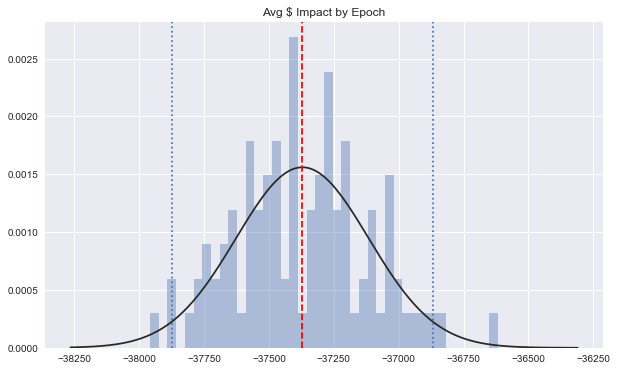

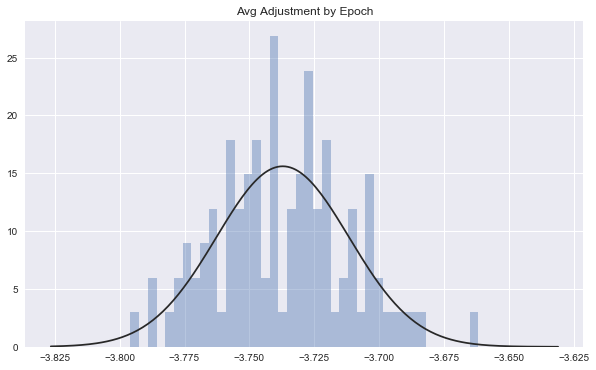

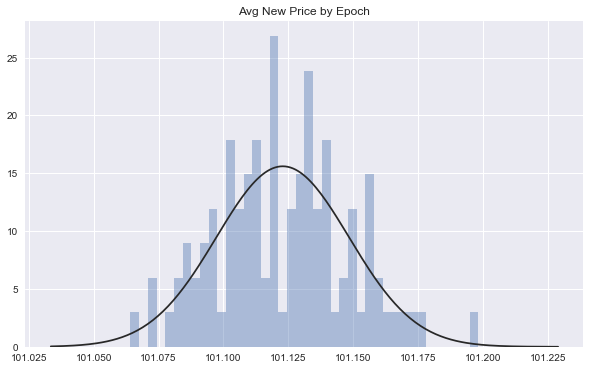

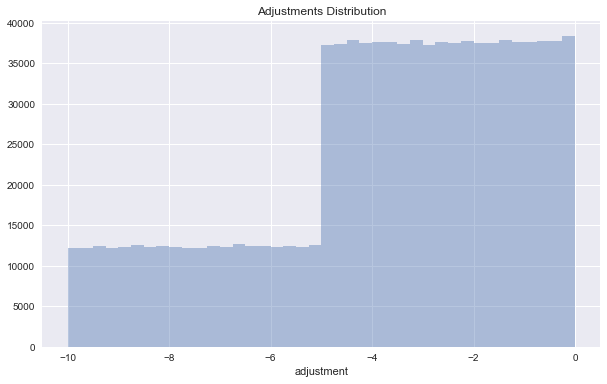

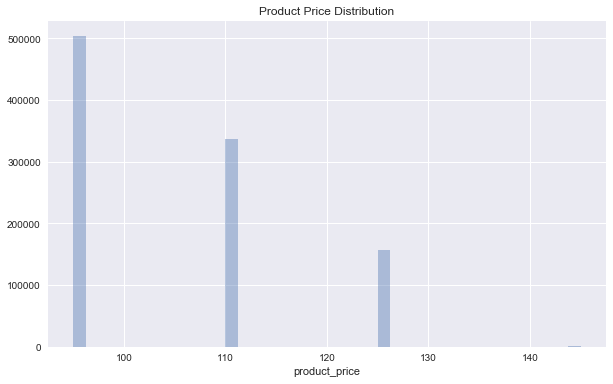

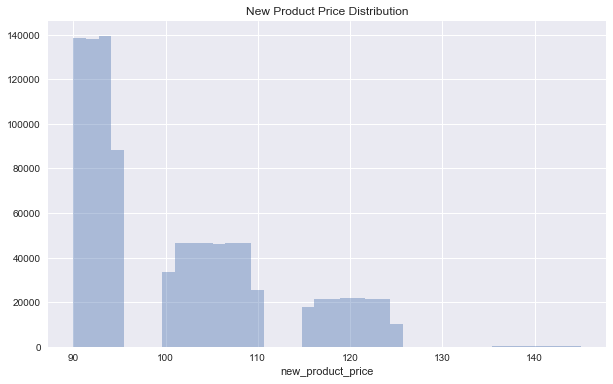

In [31]:
summary(df_results)

## What can we do better?

For starters, we should rewrite the data processing task in a functional way and get rid of the for-loop. This will make the tasks more scalable.

Fortunately, pandas make this easy, and in fact, this is the preferred way to work with pandas dataframes.

The .loc accessor allows us to make updates to subsets of the data based on product_price. 

[This is known as split-apply-combine]

In [32]:
def my_data_processing_function(data, epoch):
    
    np.random.seed(epoch)
    random_numbers = np.random.uniform(0, 1, size=len(data))
    
    # add random adjustment for suits > $110
    fltr = (data['product_price'] >= 110)
    data.loc[fltr, 'adjustment'] = -1 * np.round(10 * random_numbers[fltr], 2)
    
    fltr = (data['product_price'] < 110)
    data.loc[fltr, 'adjustment'] = -1 * np.round(5 * random_numbers[fltr], 2)

    data.loc[:, 'new_product_price'] = data['product_price'] + data['adjustment']
    
    return data

We'll run this function along the entire dataframe in a parallelizable way (more on that later). 
- To make sure we don't modify the original dataframe, but only process one epoch per call, we copy the incoming dataframe
- Instead of passing back the dataframe, we save the data locally and just pass back the file name. This reduces the memory overhead.
- There are projects like [dask](https://dask.pydata.org/en/latest/) and [bcolz](https://bcolz.readthedocs.io/en/latest/) that optimize this in more clever ways

In [33]:
def my_parallelizable_function(data, epoch):
    
    df = data.copy()
    
    df.loc[:, 'epoch'] = epoch    
    df.loc[:, 'version'] = 'my_parallelizable_function'    

    # use apply on each group
    df_result = df.groupby(['product_id']).apply(my_data_processing_function, epoch)
    
    file_name = '_tmp/result_{:}.csv'.format(epoch)
    df_result.to_csv(file_name, index=False)
    
    return file_name

We run this in sequence for now:

In [34]:
def run_simulation_sequence(data, epochs):

    """
    Runs simulation for number of epochs
    """
    """
    Run a loop for each epoch
    """
    results = []
    
    for epoch in tqdm(range(0, epochs, 1)):
        results.append(my_parallelizable_function(data, epoch))

    return results

In [35]:
epochs = 100
results = run_simulation_sequence(df, epochs)

100%|██████████| 100/100 [00:24<00:00,  4.34it/s]


This is about 2x faster already for 100 epochs!

In [36]:
df_results = make_dataframe(results)
df_results.sample(10)

,order_id,product_id,product_name,product_price,checkouts,epoch,version,adjustment,new_product_price
2939,7029934,368,Midnight Pin Dot Tuxedo,125.0,1,93,my_parallelizable_function,-8.44,116.56
8682,7078481,60,Charcoal Suit,95.0,1,47,my_parallelizable_function,-1.09,93.91
5768,7078818,57,Notch Lapel Tuxedo,95.0,1,28,my_parallelizable_function,-4.05,90.95
372,6946896,214,Navy Suit,95.0,1,17,my_parallelizable_function,-3.88,91.12
6385,7189690,61,Grey Suit,95.0,1,51,my_parallelizable_function,-2.65,92.35
6828,6940471,59,Peak Lapel Tuxedo,110.0,1,81,my_parallelizable_function,-1.39,108.61
9594,7008692,280,Tan Suit,110.0,1,25,my_parallelizable_function,-3.67,106.33
1388,7067319,57,Notch Lapel Tuxedo,95.0,1,73,my_parallelizable_function,-0.45,94.55
1479,7154808,214,Navy Suit,95.0,1,15,my_parallelizable_function,-3.85,91.15
6705,7001196,59,Peak Lapel Tuxedo,110.0,1,31,my_parallelizable_function,-4.58,105.42


Avg $ Discount (Total) 	$-37,240
Min $ Discount (Total) 	$-35,458
Max $ Discount (Total) 	$-38,598
95% Conf. Int. (Total) 	$-35,941 	$-38,538

 count    1000000.00
mean          -3.72
std            2.59
min          -10.00
25%           -4.97
50%           -3.30
75%           -1.65
max           -0.00
Name: adjustment, dtype: float64


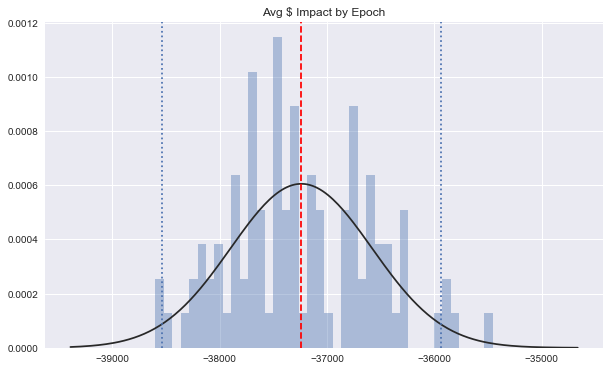

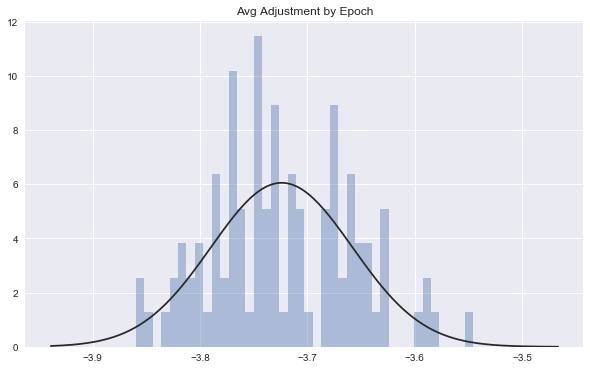

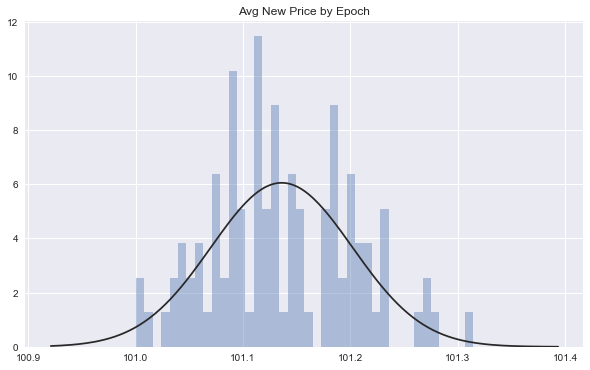

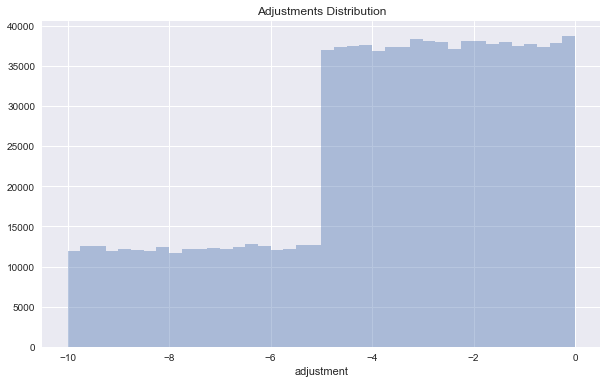

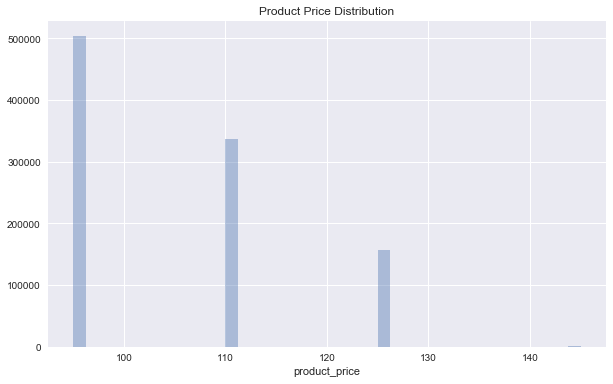

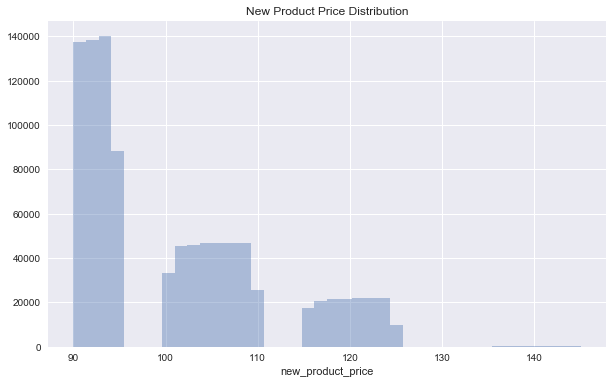

In [37]:
summary(df_results)

Since we only ran 100 simulations, our data looks a little jagged, so we're not sure how reliable the mean we calculated is going to be. We'd like to run a lot more simulations, but we don't want to wait 10x.

### How do we run more than 1 of these?

The joblib module provides an easy interface to run functions in parallel, either in separate threads (less ideal) or separate processes. 

We prefer separate processes in this case, which starts a new Python executable with its own GIL. Since we're running an embarrasingly parallelizable task, no data has to be shared (marshalled) between processes.

In [38]:
from joblib import Parallel, parallel_backend, delayed

def run_simulation_parallel(data, epochs):

    """
    Runs simulation for number of epochs
    """
    backend = parallel_backend('multiprocessing')
    num_cores = multiprocessing.cpu_count()
    
    # We can either run this across all available processor by explicitly setting the number, 
    # or let Python chose by setting this to -1
    N_JOBS = num_cores

    """
    Set up a process for each epoch and run the function
    """
    with backend:
        # the Parallel call returns a list of function return values
        results = Parallel(n_jobs=N_JOBS, verbose=10)(
                delayed(my_parallelizable_function)(data, epoch)
                for epoch in range(0, epochs, 1)
        )

    return results

In [39]:
epochs = 100
results = run_simulation_parallel(df, epochs)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done  96 out of 100 | elapsed:    6.3s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.6s finished


We get another 3-4x improvement!

In [40]:
df_results = make_dataframe(results)
df_results.sample(10)

,order_id,product_id,product_name,product_price,checkouts,epoch,version,adjustment,new_product_price
7289,7077219,60,Charcoal Suit,95.0,1,91,my_parallelizable_function,-1.42,93.58
3289,7130888,57,Notch Lapel Tuxedo,95.0,1,47,my_parallelizable_function,-2.22,92.78
6539,7169441,59,Peak Lapel Tuxedo,110.0,1,64,my_parallelizable_function,-8.99,101.01
9550,6881609,57,Notch Lapel Tuxedo,95.0,1,53,my_parallelizable_function,-0.99,94.01
7443,7173570,61,Grey Suit,95.0,1,75,my_parallelizable_function,-0.19,94.81
9212,7172415,61,Grey Suit,95.0,1,31,my_parallelizable_function,-2.27,92.73
5902,7078152,61,Grey Suit,95.0,1,9,my_parallelizable_function,-3.68,91.32
2997,7154045,61,Grey Suit,95.0,1,89,my_parallelizable_function,-3.72,91.28
8454,7237423,405,Black Suit,110.0,1,25,my_parallelizable_function,-0.74,109.26
3005,7063075,404,Light Grey Suit,110.0,1,66,my_parallelizable_function,-9.03,100.97


Avg $ Discount (Total) 	$-37,240
Min $ Discount (Total) 	$-35,458
Max $ Discount (Total) 	$-38,598
95% Conf. Int. (Total) 	$-35,941 	$-38,538

 count    1000000.00
mean          -3.72
std            2.59
min          -10.00
25%           -4.97
50%           -3.30
75%           -1.65
max           -0.00
Name: adjustment, dtype: float64


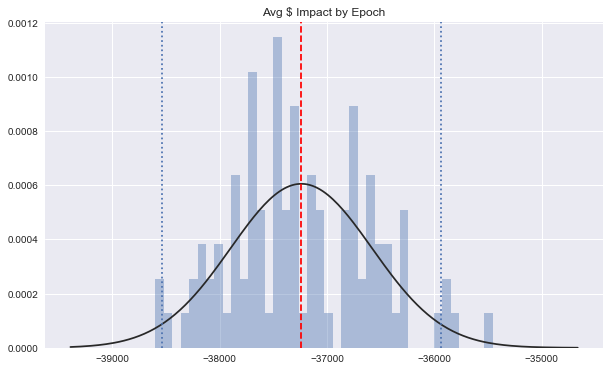

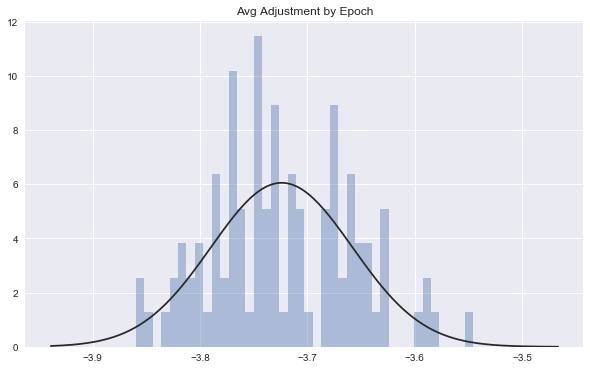

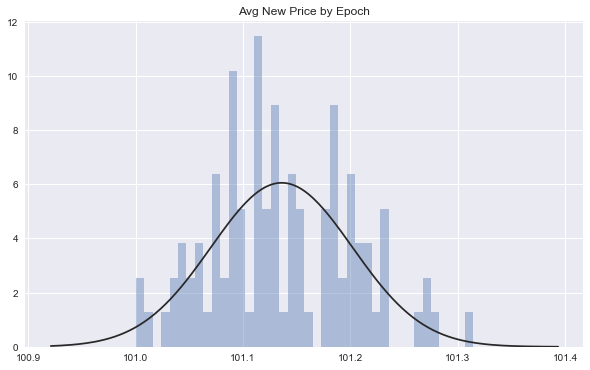

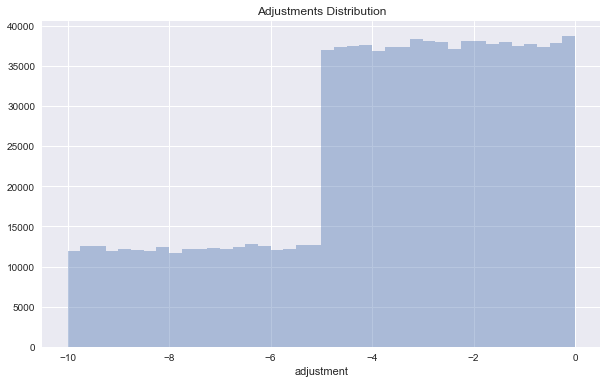

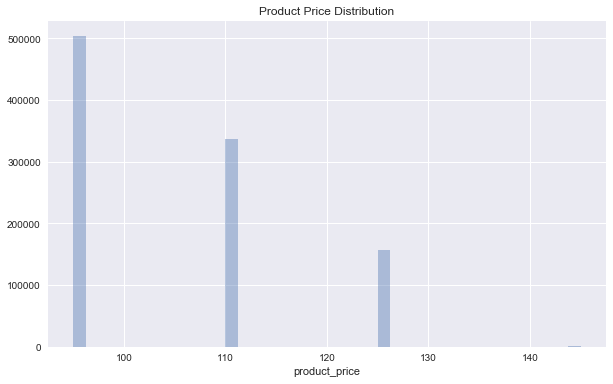

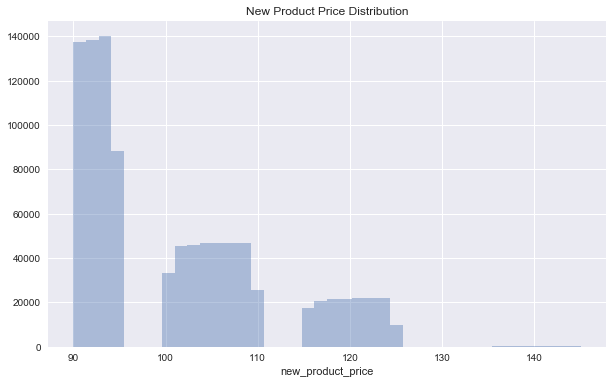

In [41]:
summary(df_results)

Which means, we can now run more meaningful simulations with more than 100 epochs:

In [42]:
epochs = 1000
results = run_simulation_parallel(df, epochs)

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    5.3s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:   10.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:   12.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed:   15.7s
[Parallel(n_jobs=8)]: Do

In [43]:
df_results = make_dataframe(results)
df_results.head()

,order_id,product_id,product_name,product_price,checkouts,epoch,version,adjustment,new_product_price
0,7183186,59,Peak Lapel Tuxedo,110.0,1,0,my_parallelizable_function,-5.49,104.51
1,7240780,424,Blue Suit,110.0,1,0,my_parallelizable_function,-5.49,104.51
2,7227990,214,Navy Suit,95.0,1,0,my_parallelizable_function,-2.74,92.26
3,6996149,61,Grey Suit,95.0,1,0,my_parallelizable_function,-2.74,92.26
4,7201848,404,Light Grey Suit,110.0,1,0,my_parallelizable_function,-5.49,104.51


Avg $ Discount (Total) 	$-37,406
Min $ Discount (Total) 	$-35,117
Max $ Discount (Total) 	$-39,794
95% Conf. Int. (Total) 	$-36,105 	$-38,707

 count    10000000.00
mean           -3.74
std             2.60
min           -10.00
25%            -4.99
50%            -3.32
75%            -1.66
max            -0.00
Name: adjustment, dtype: float64


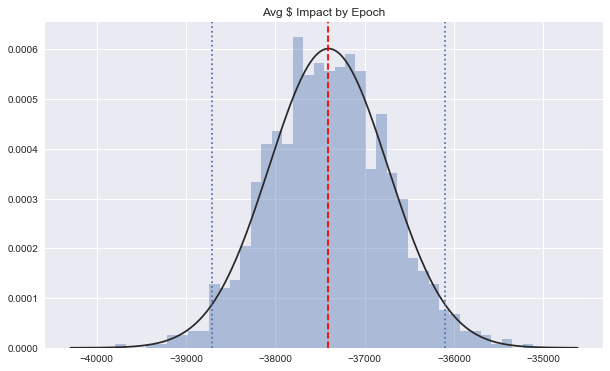

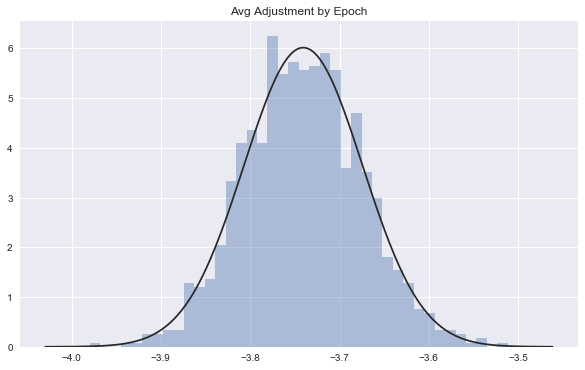

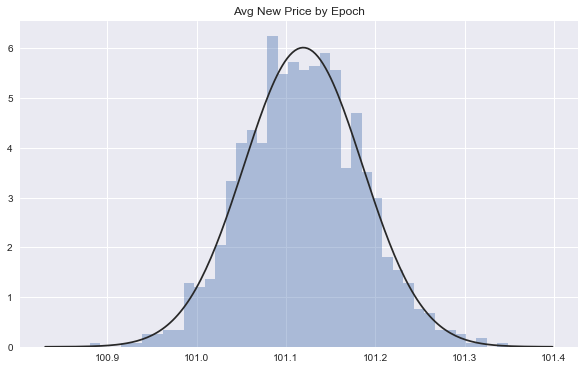

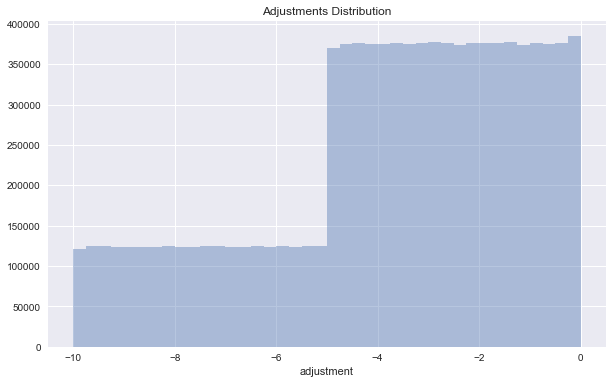

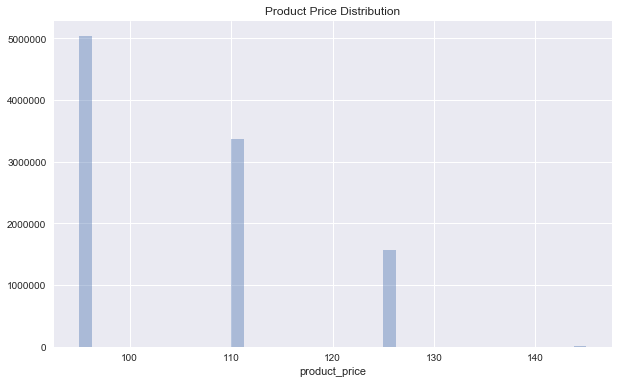

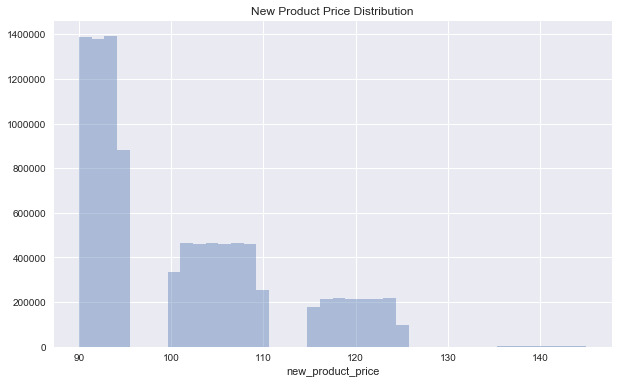

In [44]:
summary(df_results)

# Math works!

## Other use cases?

For example, uploading files to s3:

In [ ]:
import s3fs
import os

s3 = s3fs.S3FileSystem()

remote_bucket_name = 'data.theblacktux.com/test/{:}'

#### We generate some test files with data:

In [ ]:
test_data = 'This, is, a, test\n'
test_data_lines = [test_data for i in range(0, 100)]
test_data_lines_txt = ''.join(test_data_lines)

In [ ]:
local_files = []
for i in range(0, 100):
    local_path = '_tmp/test_file_{:}.csv'.format(i)
    with open(local_path, 'w') as f:
        f.write(test_data_lines_txt)
    local_files.append(local_path)
len(local_files)

In [ ]:
local_files[-10:]

In [ ]:
remote_paths = [remote_bucket_name.format(os.path.basename(f)) for f in local_files]
len(remote_paths)

In [ ]:
remote_paths[-10:]

### Our first attempt is using a standard loop
We transfer one file at a time:

In [ ]:
for i, f in enumerate(zip(local_files, remote_paths)):
    if i % 9 == 0:
        print(f)
    l, r = f
    s3.put(l, r)

Better, and faster, would be to use the threading backend. We setup a threadpool if size n and transfer files in batches of n. 
Since we're not worried about processing power, but parallel throughput, threading makes more sense here than separate processes:

In [ ]:
backend = parallel_backend('threading')

with backend:

    Parallel(n_jobs=50, backend='threading', verbose=10)(
            delayed(s3.put)(l, r) for l, r in zip(local_files, remote_paths)
    )